In [ ]:
# ===========================
# Linear Regression Notebook - Başlangıç imports
# ===========================
import sys
import os
import pandas as pd
import numpy as np

# Projenin kök klasörünü Python path’e ekle
project_root = r"C:\Users\esram\OneDrive\Desktop\esrabecode\immo-eliza-ml"
sys.path.append(project_root)

# Linear model scriptinden gerekli fonksiyonları import et
from scripts.linear_model import run_linear_pipeline, plot_linear_pipeline_results


In [ ]:
# CSV dosyasını oku
file_path = r"C:\Users\esram\OneDrive\Desktop\esrabecode\immo-eliza-ml\data\immovlan_cleaned_file_final.csv"
df = pd.read_csv(file_path)

# Price boş olanları çıkar
df = df.dropna(subset=['Price'])


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

# =========================================================
# 🔥 MASTER FUNCTION — Linear Regression Pipeline
# =========================================================
def run_linear_pipeline(df, log_transform=True):
    """
    Runs a full linear regression pipeline:
    - Remove outliers early
    - Drop unwanted columns
    - Missing value handling
    - Train/Validation/Test split
    - Encoding categorical variables
    - Scaling numeric features
    - Optional log-transform of target
    """

    # -----------------------------
    # 0️⃣ Remove price <= 1 & drop unwanted columns
    # -----------------------------
    df = df[df['Price'] > 1]

    drop_cols = [
        'Property ID', 'url', 'Availability', 'Attic', 'Kitchen equipment',
        'Kitchen type', 'Furnished', 'Price_per_sqm_land', 'price_per_sqm',
        'Number of facades', 'Number of bathrooms', 'Number of showers',
        'Number of toilets', 'Surface garden', 'Type of glazing'
    ]
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    # -----------------------------
    # 1️⃣ Outlier removal (before split)
    # -----------------------------
    outlier_num_cols = ['Number of bedrooms', 'Livable surface', 'Garage', 'Number of garages', 
                        'Terrace', 'Surface terrace', 'Total land surface', 'Swimming pool']

    df_no_outliers_list = []
    for mtype, group in df.groupby('main_type'):
        group_copy = group.copy()
        z_scores = np.abs(stats.zscore(group_copy[outlier_num_cols], nan_policy='omit'))
        outliers = (z_scores > 3).any(axis=1)
        df_no_outliers_list.append(group_copy[~outliers])
    df = pd.concat(df_no_outliers_list)

    # -----------------------------
    # 2️⃣ Missing value handling
    # -----------------------------
    zero_cols = ['Garage', 'Number of garages', 'Swimming pool', 
                 'Terrace', 'Surface terrace', 'Elevator', 'Garden']
    for col in zero_cols:
        df[col].fillna(0, inplace=True)

    categorical_cols = ['Type of heating', 'State of the property']
    for col in categorical_cols:
        df[col].fillna('unknown', inplace=True)

    df['main_type'].fillna('unknown', inplace=True)

    # Special handling for Total land surface
    df.loc[df['main_type']=='apartment', 'Total land surface'].fillna(0, inplace=True)
    house_median = df.loc[df['main_type']=='house', 'Total land surface'].median()
    land_median  = df.loc[df['main_type']=='land', 'Total land surface'].median()
    df.loc[(df['main_type']=='house') & (df['Total land surface'].isna()), 'Total land surface'] = house_median
    df.loc[(df['main_type']=='land') & (df['Total land surface'].isna()), 'Total land surface'] = land_median

    num_cols_for_median = ['Number of bedrooms', 'Livable surface', 'Total land surface']
    median_dicts = df.groupby('main_type')[num_cols_for_median].median()
    for col in num_cols_for_median:
        for mtype, med_val in median_dicts[col].items():
            df.loc[(df['main_type']==mtype) & (df[col].isna()), col] = med_val
    for col in num_cols_for_median:
        df[col].fillna(df[col].median(), inplace=True)

    # -----------------------------
    # 3️⃣ Train/Validation/Test split
    # -----------------------------
    X = df.drop(columns=['Price'])
    y = df['Price']
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # -----------------------------
    # 4️⃣ Encode categorical variables
    # -----------------------------
    cat_cols = ['State of the property', 'Type of heating','type', 
                'city', 'Region', 'province', 'main_type']
    cat_cols_existing = [c for c in cat_cols if c in X_train.columns]

    X_tr_encoded = pd.get_dummies(X_train, columns=cat_cols_existing, drop_first=True)
    X_val_encoded = pd.get_dummies(X_val, columns=cat_cols_existing, drop_first=True)
    X_test_encoded = pd.get_dummies(X_test, columns=cat_cols_existing, drop_first=True)

    train_cols = X_tr_encoded.columns
    X_val_encoded = X_val_encoded.reindex(columns=train_cols, fill_value=0)
    X_test_encoded = X_test_encoded.reindex(columns=train_cols, fill_value=0)

    # -----------------------------
    # 5️⃣ Scale numeric features
    # -----------------------------
    scaler = StandardScaler()
    num_cols_scaled = ['Number of bedrooms', 'Livable surface', 'Number of garages', 
                       'Surface terrace', 'Total land surface']
    X_tr_encoded[num_cols_scaled] = scaler.fit_transform(X_tr_encoded[num_cols_scaled])
    X_val_encoded[num_cols_scaled] = scaler.transform(X_val_encoded[num_cols_scaled])
    X_test_encoded[num_cols_scaled] = scaler.transform(X_test_encoded[num_cols_scaled])

    # -----------------------------
    # 6️⃣ Optional log-transform target
    # -----------------------------
    if log_transform:
        y_tr_log = np.log1p(y_train)
        y_val_log = np.log1p(y_val)
        y_test_log = np.log1p(y_test)
    else:
        y_tr_log = y_train
        y_val_log = y_val
        y_test_log = y_test

    # -----------------------------
    # 7️⃣ Train Linear Regression
    # -----------------------------
    lr_model = LinearRegression()
    lr_model.fit(X_tr_encoded, y_tr_log)

    y_train_pred_log = lr_model.predict(X_tr_encoded)
    y_val_pred_log   = lr_model.predict(X_val_encoded)
    y_test_pred_log  = lr_model.predict(X_test_encoded)

    # -----------------------------
    # 8️⃣ Evaluation
    # -----------------------------
    def evaluate_log(y_true, y_pred_log, label="Set"):
        if log_transform:
            y_pred_inv = np.expm1(y_pred_log)
        else:
            y_pred_inv = y_pred_log
        rmse = np.sqrt(mean_squared_error(y_true, y_pred_inv))
        r2 = r2_score(y_true, y_pred_inv)
        print(f"{label} → RMSE: {rmse:.2f}, R²: {r2:.4f}")

    evaluate_log(y_train, y_train_pred_log, "Train")
    evaluate_log(y_val, y_val_pred_log, "Validation")
    evaluate_log(y_test, y_test_pred_log, "Test")

    return lr_model, X_tr_encoded, X_val_encoded, X_test_encoded, y_train, y_val, y_test


In [ ]:
model, X_tr, X_val, X_test, y_tr, y_val, y_test = run_linear_pipeline(df.copy(), log_transform=True)


Train → RMSE: 244275.90, R²: 0.4210
Validation → RMSE: 185367.68, R²: 0.5033
Test → RMSE: 208652.38, R²: 0.4800


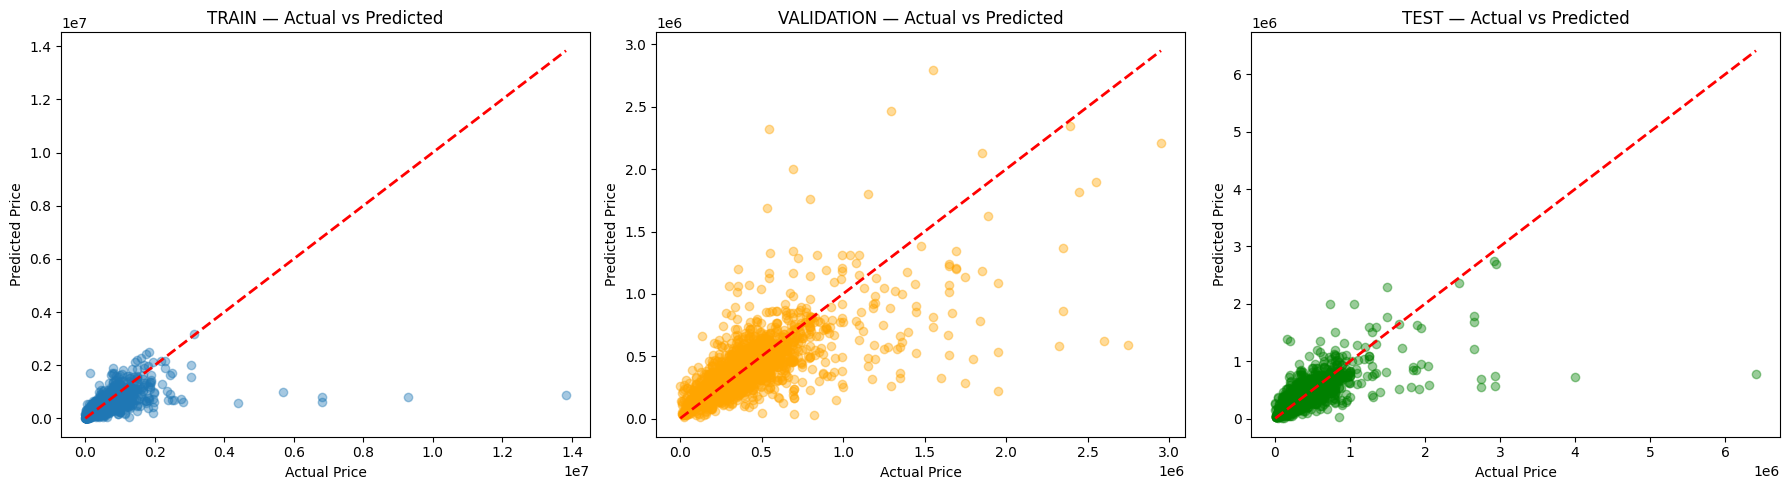

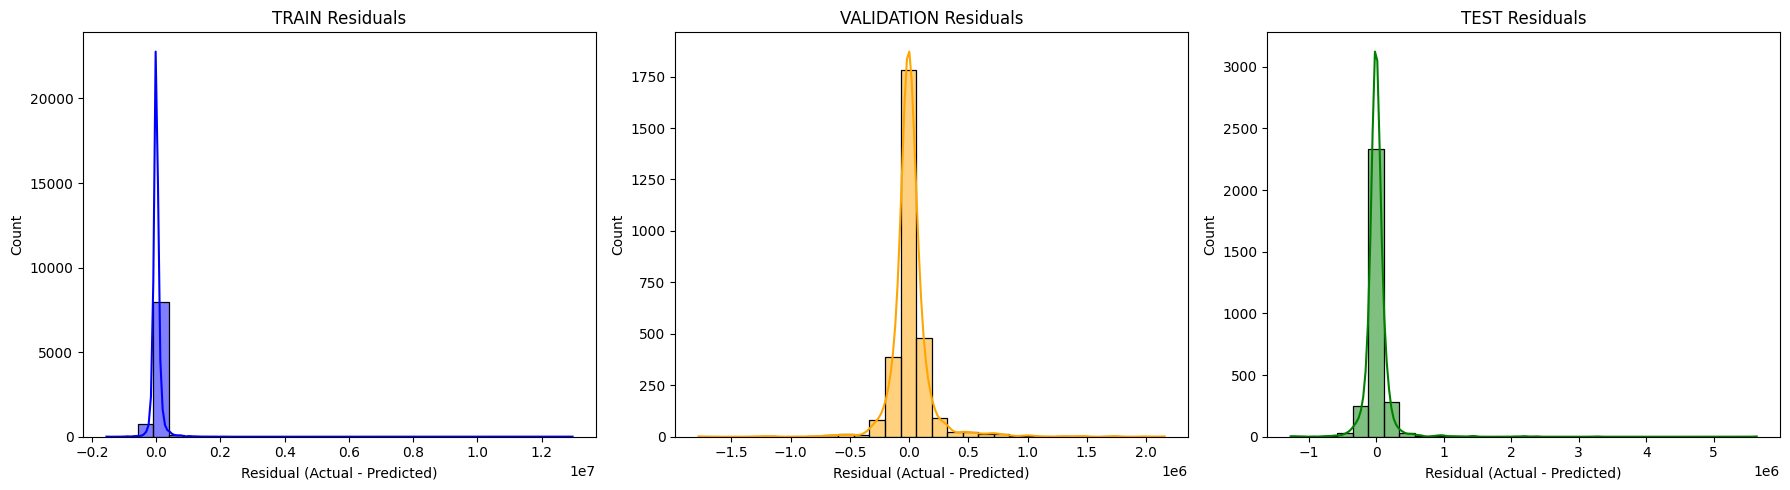

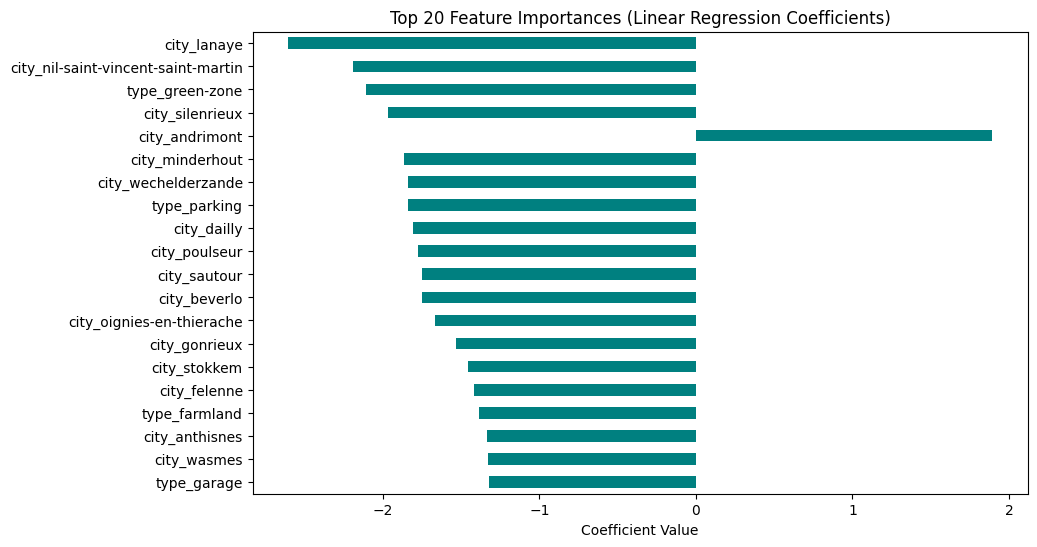

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_linear_pipeline_results(model, X_tr, X_val, X_test, y_tr, y_val, y_test, log_transform=True, top_n_features=20):
    """
    Plots for Linear Regression pipeline:
    1️⃣ Actual vs Predicted (Train / Val / Test)
    2️⃣ Residual plots (Train / Val / Test)
    3️⃣ Feature importance (coefficients)
    """
    # ---- Predictions ----
    y_train_pred = model.predict(X_tr)
    y_val_pred   = model.predict(X_val)
    y_test_pred  = model.predict(X_test)
    
    # Inverse log if needed
    if log_transform:
        y_train_pred_inv = np.expm1(y_train_pred)
        y_val_pred_inv   = np.expm1(y_val_pred)
        y_test_pred_inv  = np.expm1(y_test_pred)
    else:
        y_train_pred_inv = y_train_pred
        y_val_pred_inv   = y_val_pred
        y_test_pred_inv  = y_test_pred
    
    # ---- Actual vs Predicted Plots ----
    plt.figure(figsize=(18,5))
    
    plt.subplot(1,3,1)
    plt.scatter(y_tr, y_train_pred_inv, alpha=0.4)
    plt.plot([y_tr.min(), y_tr.max()], [y_tr.min(), y_tr.max()], 'r--', linewidth=2)
    plt.title("TRAIN — Actual vs Predicted")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    
    plt.subplot(1,3,2)
    plt.scatter(y_val, y_val_pred_inv, alpha=0.4, color='orange')
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)
    plt.title("VALIDATION — Actual vs Predicted")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    
    plt.subplot(1,3,3)
    plt.scatter(y_test, y_test_pred_inv, alpha=0.4, color='green')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
    plt.title("TEST — Actual vs Predicted")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    
    plt.tight_layout()
    plt.show()
    
    # ---- Residual Plots ----
    plt.figure(figsize=(18,5))
    
    plt.subplot(1,3,1)
    sns.histplot(y_tr - y_train_pred_inv, bins=30, kde=True, color='blue')
    plt.title("TRAIN Residuals")
    plt.xlabel("Residual (Actual - Predicted)")
    
    plt.subplot(1,3,2)
    sns.histplot(y_val - y_val_pred_inv, bins=30, kde=True, color='orange')
    plt.title("VALIDATION Residuals")
    plt.xlabel("Residual (Actual - Predicted)")
    
    plt.subplot(1,3,3)
    sns.histplot(y_test - y_test_pred_inv, bins=30, kde=True, color='green')
    plt.title("TEST Residuals")
    plt.xlabel("Residual (Actual - Predicted)")
    
    plt.tight_layout()
    plt.show()
    
    # ---- Feature Importance (Coefficients) ----
    coefs = pd.Series(model.coef_, index=X_tr.columns).sort_values(key=abs, ascending=False)
    plt.figure(figsize=(10,6))
    coefs.head(top_n_features).plot(kind='barh', color='teal')
    plt.gca().invert_yaxis()
    plt.title(f"Top {top_n_features} Feature Importances (Linear Regression Coefficients)")
    plt.xlabel("Coefficient Value")
    plt.show()

# Kullanımı
plot_linear_pipeline_results(model, X_tr, X_val, X_test, y_tr, y_val, y_test, log_transform=True)
